In [502]:
# import pickle,os

# data_list = range(0,3229)
# for data_number in data_list:
#     if os.path.exists('../data/both57m_rigged/%d.pkl' % data_number):
#         with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
#             data = pickle.load(f)
        
#         full_annot = data['full_annot']
#         print(data_number, full_annot,"\n")

In [503]:
# import pickle, os

# data_list = range(2830,2850)
# for data_number in data_list:
#     file_name = '../data/both57m_rigged/%d.pkl' % data_number
#     if os.path.exists(file_name) == True:
#         with open(file_name, 'rb') as f:
#             data = pickle.load(f)
        
#         data_length = data['length']
#         if data_length != 150:
#             print(data_number, data_length)

In [504]:
data_range = range(493,496)
start_offset = 38
end_offset = 52

In [505]:
import torch,sys,pickle
import numpy as np
sys.path.append('../utils')
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,get_idxs,np_uv
from smplx import MANO

comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_path = '../asset/smplh_rig/scene_smplh_rig.xml'
env = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=False)
left_mano_path = '../models/mano_models/MANO_LEFT.pkl'
right_mano_path = '../models/mano_models/MANO_RIGHT.pkl'

left_model = MANO(model_path=left_mano_path,is_rhand=False,use_pca=False,flat_hand_mean=True).to(comp_device)
right_model = MANO(model_path=right_mano_path,is_rhand=True,use_pca=False,flat_hand_mean=True).to(comp_device)

smplh_right_shoulder_pos = env.get_p_joint('r_shoulder1')
smplh_right_wrist_pos = env.get_p_joint('r_wrist1')
smplh_left_shoulder_pos = env.get_p_joint('l_shoulder1')
smplh_arm_length = np.linalg.norm(smplh_right_shoulder_pos-smplh_right_wrist_pos)

# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]

In [506]:
data_numbers = data_range
ZERO_ROOT = True

video = []
tick = 0
seq_len = 0

qpos_rig_data = np.empty((0,env.model.nq))
left_joint_pos_array_full = np.empty((0,21,3))
right_joint_pos_array_full = np.empty((0,21,3))

mano2mp = [0,17,18,19,20,1,2,3,4,5,6,7,8,13,14,15,16,9,10,11,12]
MANO_LEFT_UP = np.array([[0, -1, 0],[0, 0, -1],[1, 0, 0]])
MANO_RIGHT_UP = np.array([[0, -1, 0],[0, 0, 1],[-1, 0, 0]])

for data_number in data_numbers:
    with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
        data = pickle.load(f)

    qpos_rig_data = np.concatenate((qpos_rig_data, data['qpos']), axis=0)
    seq_len += data['length']

    hand_data_path = '../data/both57m/%d/data.npz'%(data_number)
    hand_data = np.load(hand_data_path)
    hand_seq_len = hand_data['seq_len']

    hand_pose = torch.Tensor(hand_data['hand_pose'].reshape((hand_seq_len,-1))).to(comp_device)
    left_hand_pose = hand_pose[:,:45]
    right_hand_pose = hand_pose[:,45:]

    left_joint_pos_list = []
    right_joint_pos_list = []
    left_extra_joints_idxs = left_model.vertex_joint_selector.extra_joints_idxs
    right_extra_joints_idxs = right_model.vertex_joint_selector.extra_joints_idxs
    finger_idxs = [0,1,2,3,5,6,7,9,10,11,13,14,15,17,18,19]
    fingertip_idxs = [20,4,8,16,12]

    for i in range(hand_seq_len):
        left_output = left_model(hand_pose=left_hand_pose[i].unsqueeze(0),return_verts=True)
        left_finger_pos_output = left_output.joints.detach().cpu().numpy().squeeze()
        left_fingertip_pos_output = left_output.vertices[:,left_extra_joints_idxs,:].detach().cpu().numpy().squeeze()
        left_full_joint_pos = np.zeros((21,3))
        left_full_joint_pos[finger_idxs] = left_finger_pos_output
        left_full_joint_pos[fingertip_idxs] = left_fingertip_pos_output
        left_joint_pos_list.append(left_full_joint_pos)

        right_output = right_model(hand_pose=right_hand_pose[i].unsqueeze(0),return_verts=True)
        right_finger_pos_output = right_output.joints.detach().cpu().numpy().squeeze()
        right_fingertip_pos_output = right_output.vertices[:,right_extra_joints_idxs,:].detach().cpu().numpy().squeeze()
        right_full_joint_pos = np.zeros((21,3))
        right_full_joint_pos[finger_idxs] = right_finger_pos_output
        right_full_joint_pos[fingertip_idxs] = right_fingertip_pos_output
        right_joint_pos_list.append(right_full_joint_pos)

    left_joint_pos_array = np.array(left_joint_pos_list)[:,mano2mp]
    right_joint_pos_array = np.array(right_joint_pos_list)[:,mano2mp]

    for i in range(hand_seq_len):
        left_joint_pos_array[i] = np.matmul(MANO_LEFT_UP,left_joint_pos_array[i].T).T
        right_joint_pos_array[i] = np.matmul(MANO_RIGHT_UP,right_joint_pos_array[i].T).T

    left_joint_pos_array_full = np.concatenate((left_joint_pos_array_full, left_joint_pos_array), axis=0)
    right_joint_pos_array_full = np.concatenate((right_joint_pos_array_full, right_joint_pos_array), axis=0)

In [507]:
start_tick = start_offset
end_tick = seq_len - end_offset
final_len = end_tick - start_tick

ls2le_array = np.zeros((final_len,3))
le2lw_array = np.zeros((final_len,3))
rs2re_array = np.zeros((final_len,3))
re2rw_array = np.zeros((final_len,3))
lw_rot_array = np.zeros((final_len,3,3))
rw_rot_array = np.zeros((final_len,3,3))
lh_array = np.zeros((final_len,6))
rh_array = np.zeros((final_len,6))

left_joint_pos_array_full = left_joint_pos_array_full[start_tick:end_tick]
right_joint_pos_array_full = right_joint_pos_array_full[start_tick:end_tick]

while tick < end_tick-start_tick:
    q_rig = qpos_rig_data[tick+start_tick,:]
    coupled_joint_idxs_list = [[47,48],[31,32,33],[34,35,36],[42,43,44],[38,39,40],[41,37],
                                [74,75],[58,59,60],[61,62,63],[65,66,67],[69,70,71],[68,64]]

    coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5],
                                    [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5]]
    
    q_couple = env.get_q_couple(
        q_raw=q_rig,
        coupled_joint_idxs_list=coupled_joint_idxs_list,
        coupled_joint_weights_list=coupled_joint_weights_list)

    if ZERO_ROOT:
        q_rig[3:7] = 0
    
    env.forward(q=q_rig,INCREASE_TICK=True)
    ls = env.get_p_body('left_shoulder')
    le = env.get_p_body('left_elbow')
    lw = env.get_p_body('left_wrist')
    rs = env.get_p_body('right_shoulder')
    re = env.get_p_body('right_elbow')
    rw = env.get_p_body('right_wrist')

    ls2le_array[tick,:] = np_uv(le-ls)
    le2lw_array[tick,:] = np_uv(lw-le)
    rs2re_array[tick,:] = np_uv(re-rs)
    re2rw_array[tick,:] = np_uv(rw-re)
    lw_rot_array[tick,:] = env.get_R_body('left_wrist')
    rw_rot_array[tick,:] = env.get_R_body('right_wrist')
    tick = tick + 1

In [508]:
SAVE_VIDEO = False
vis_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

while vis_tick < final_len:
    q_rig = qpos_rig_data[vis_tick+start_tick,:]
    env.forward(q=q_rig,INCREASE_TICK=True)

    # Plot world frame
    env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
    env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label="tick:[%d/%d]"%(vis_tick,final_len))
    env.render()  
    frame = env.grab_image()
    video.append(frame)

    for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        axis_joint = env.model.jnt_axis[rev_joint_idx]
        p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        axis_world = R_joint@axis_joint
        axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        axis_len,axis_r = 0.02,0.002
        env.plot_arrow_fr2to(
            p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
            r=axis_r,rgba=axis_rgba)

    vis_tick = vis_tick + 1
    # if vis_tick == final_len:
    #     if not SAVE_VIDEO: vis_tick = 0

env.close_viewer()

if SAVE_VIDEO:
    import mediapy as media
    media.show_video(images=video,fps=15,width=700)

In [509]:
recon_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['left_elbow','left_wrist','right_elbow','right_wrist']
JOINT_NAMES = ['l_shoulder1', 'l_shoulder2', 'l_shoulder3', 'l_elbow', 'l_wrist1', 'l_wrist2', 'l_wrist3',
               'r_shoulder1', 'r_shoulder2', 'r_shoulder3', 'r_elbow', 'r_wrist1', 'r_wrist2', 'r_wrist3']

hand_indices = list(range(27,49)) + list(range(54,76))
video = []
wrist_dist_list = []
smplh_lw_pos_list = []
smplh_rw_pos_list = []
q_smplh_up_list = []

ls = env.get_p_body('left_shoulder')
le = env.get_p_body('left_elbow')
lw = env.get_p_body('left_wrist')
rs = env.get_p_body('right_shoulder')
re = env.get_p_body('right_elbow')
rw = env.get_p_body('right_wrist')

len_ls2le = np.linalg.norm(le-ls)
len_le2lw = np.linalg.norm(lw-le)
len_rs2re = np.linalg.norm(re-rs)
len_re2rw = np.linalg.norm(rw-re)

while recon_tick < final_len:
    p_target = {}
    p_target['left_elbow'] = ls + len_ls2le * ls2le_array[recon_tick,:]
    p_target['left_wrist'] = p_target['left_elbow'] + len_le2lw * le2lw_array[recon_tick,:]
    p_target['right_elbow'] = rs + len_rs2re * rs2re_array[recon_tick,]
    p_target['right_wrist'] = p_target['right_elbow'] + len_re2rw * re2rw_array[recon_tick,:]
    
    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-4:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = None
                IK_P = True
                IK_R = False
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_rig = qpos_rig_data[recon_tick+start_tick,:]
    q_env[hand_indices] = q_rig[hand_indices]
    env.forward(q=q_env,INCREASE_TICK=True)
    q_smplh_up_list.append(q_env)

    left_wrist_pos = env.get_p_body('left_wrist')
    right_wrist_pos = env.get_p_body('right_wrist')
    smplh_lw_pos_list.append(left_wrist_pos)
    smplh_rw_pos_list.append(right_wrist_pos)
    wrist_dist = np.linalg.norm(left_wrist_pos - right_wrist_pos)
    wrist_dist_list.append(wrist_dist)
    wrist_pos = np.vstack((left_wrist_pos,right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(recon_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.plot_traj(wrist_pos,rgba=[0,0,1,1],plot_line=True,plot_sphere=True,sphere_r=0.005)
    env.render()

    video.append(env.grab_image())
    recon_tick += 1

q_smplh_up_array = np.array(q_smplh_up_list)
env.close_viewer()

import mediapy as media
media.show_video(images=video,fps=15,width=700)

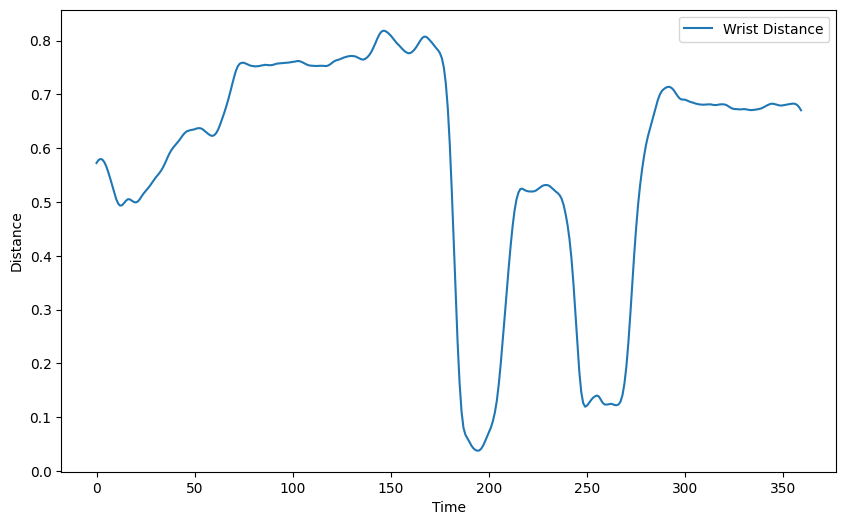

In [510]:
wrist_dist_array = np.array(wrist_dist_list)

import matplotlib.pyplot as plt

time = np.arange(0,wrist_dist_array.shape[0])
plt.figure(figsize=(10,6))
plt.plot(time, wrist_dist_array,label='Wrist Distance')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

In [511]:
sys.path.append('../ability_hand')
from pathlib import Path

from dex_retargeting.constants import RobotName, RetargetingType, HandType, get_default_config_path
from dex_retargeting.retargeting_config import RetargetingConfig

robot_name = RobotName.ability
retargeting_type = RetargetingType.dexpilot
robot_dir = Path().absolute().parent / "ability_hand" / "assets" 
RetargetingConfig.set_default_urdf_dir(str(robot_dir))

hand_type_left = HandType.left
config_path = get_default_config_path(robot_name, retargeting_type, hand_type_left)
left_retargeting = RetargetingConfig.load_from_file(config_path).build()

left_ability_joints_list = []
right_ability_joints_list = []

for i in range(final_len):
    retargeting_type = left_retargeting.optimizer.retargeting_type
    indices = left_retargeting.optimizer.target_link_human_indices
    origin_indices = indices[0, :]
    task_indices = indices[1, :]
    
    left_joint_pos = left_joint_pos_array_full[i]
    ref_value = left_joint_pos[task_indices, :] - left_joint_pos[origin_indices, :]
    left_qpos = left_retargeting.retarget(ref_value)
    left_ability_joints_list.append(left_qpos)

left_joint_names=left_retargeting.optimizer.robot.dof_joint_names
left_ability_joints_array = np.array(left_ability_joints_list)

hand_type_right = HandType.right
config_path = get_default_config_path(robot_name, retargeting_type, hand_type_right)
right_retargeting = RetargetingConfig.load_from_file(config_path).build()

for i in range(final_len):
    retargeting_type = right_retargeting.optimizer.retargeting_type
    indices = right_retargeting.optimizer.target_link_human_indices
    origin_indices = indices[0, :]
    task_indices = indices[1, :]

    right_joint_pos = right_joint_pos_array_full[i]
    ref_value = right_joint_pos[task_indices, :] - right_joint_pos[origin_indices, :]
    right_qpos = right_retargeting.retarget(ref_value)
    right_ability_joints_list.append(right_qpos)

right_joint_names=right_retargeting.optimizer.robot.dof_joint_names
right_ability_joints_array = np.array(right_ability_joints_list)

 Mimic joint adaptor enabled. The mimic joint tags in the URDF will be considered during retargeting.
To disable mimic joint adaptor, consider setting ignore_mimic_joint=True in the configuration. 
 Mimic joint adaptor enabled. The mimic joint tags in the URDF will be considered during retargeting.
To disable mimic joint adaptor, consider setting ignore_mimic_joint=True in the configuration. 


In [512]:
xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=False)
env.set_geom_color(
    rgba                = (0.2,0.2,0.2,0.9),
    body_names_to_color = [
        'robot1/end_link','robot1/index_L1','robot1/index_L2','robot1/index_tip',
        'robot1/middle_L1','robot1/middle_L2','robot1/middle_tip',
        'robot1/ring_L1','robot1/ring_L2','robot1/ring_tip',
        'robot1/pinky_L1','robot1/pinky_L2','robot1/pinky_tip',
        'robot1/thumb_L1','robot1/thumb_L2','robot1/thumb_tip',
        'robot2/end_link','robot2/index_L1','robot2/index_L2','robot2/index_tip',
        'robot2/middle_L1','robot2/middle_L2','robot2/middle_tip',
        'robot2/ring_L1','robot2/ring_L2','robot2/ring_tip',
        'robot2/pinky_L1','robot2/pinky_L2','robot2/pinky_tip',
        'robot2/thumb_L1','robot2/thumb_L2','robot2/thumb_tip'],
)

q_init = env.data.qpos.copy()
q_init[18] = -np.pi/2
env.forward(q=q_init)

robot_right_shoulder_pos = env.get_p_joint('robot2/joint1')
robot_right_wrist_pos = env.get_p_joint('robot2/joint6')
robot_left_shoulder_pos = env.get_p_joint('robot1/joint1')

robot_arm_length = np.linalg.norm(robot_right_shoulder_pos-robot_right_wrist_pos)
print ("Done.")

Done.


In [513]:
from tqdm import tqdm
SCALE_LEFT_WRIST = True
SCALE_RIGHT_WRIST = False

env.init_viewer(viewer_title='Dual Arms',viewer_width=800,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['robot1/end_link','robot2/end_link']
JOINT_NAMES = ['robot1/joint1','robot1/joint2','robot1/joint3','robot1/joint4','robot1/joint5','robot1/joint6',
               'robot2/joint1','robot2/joint2','robot2/joint3','robot2/joint4','robot2/joint5','robot2/joint6']

ls = env.get_p_body('robot1/link2')
le = env.get_p_body('robot1/link4')
lw = env.get_p_body('robot1/link6')
rs = env.get_p_body('robot2/link2')
re = env.get_p_body('robot2/link4')
rw = env.get_p_body('robot2/link6')

len_ls2le = np.linalg.norm(le-ls)
len_le2lw = np.linalg.norm(lw-le)
len_rs2re = np.linalg.norm(re-rs)
len_re2rw = np.linalg.norm(rw-re)

q_env_array = np.zeros((final_len,env.model.nq))

for tick in tqdm(range(final_len), desc="Processing"):
    p_target = {}
    delta_lw = len_ls2le * ls2le_array[tick,:] + len_le2lw * le2lw_array[tick,:]
    if SCALE_LEFT_WRIST:
        if delta_lw[0] > 0: delta_lw[0] /= 2
        delta_lw[0] += 0.2
        if delta_lw[1] > 0: delta_lw[1] /= 2
        delta_lw[2] /= 1.5
    p_target['robot1/end_link'] = ls + delta_lw
    delta_rw = len_rs2re * rs2re_array[tick,:] + len_re2rw * re2rw_array[tick,:]
    if SCALE_RIGHT_WRIST:
        if delta_rw[0] > 0: delta_rw[0] /= 2
        delta_rw[0] += 0.2
        if delta_rw[1] < 0: delta_lw[1] /= 2
        delta_rw[2] /= 1.5
    p_target['robot2/end_link'] = rs + delta_rw
    
    R_target = {}
    R_target['robot1/end_link'] = lw_rot_array[tick,:] @ rpy2r(np.radians([0,0,90]))
    R_target['robot2/end_link'] = rw_rot_array[tick,:] @ rpy2r(np.radians([0,0,-90]))

    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-3:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = R_target[ik_body_name]
                IK_P = True
                IK_R = True
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_env_array[tick,:] = q_env
    # env.render()

env.close_viewer()

Processing: 100%|██████████| 360/360 [00:01<00:00, 188.67it/s]


In [514]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = False

video = []
robot_wrist_dist_list = []
plot_tick = 0

left_hand_joint_names = ['robot1/' + i for i in left_joint_names]
left_hand_idxs = get_idxs(env.joint_names,left_hand_joint_names)
right_hand_joint_names = ['robot2/' + i for i in right_joint_names]
right_hand_idxs = get_idxs(env.joint_names,right_hand_joint_names)
hand_idxs = np.concatenate((left_hand_idxs,right_hand_idxs))

q_robot_array = np.zeros((final_len,env.model.nq))

while plot_tick < final_len and env.is_viewer_alive():
    p_target = {}
    p_target['robot1/end_link'] = ls + len_ls2le * ls2le_array[plot_tick,:] + len_le2lw * le2lw_array[plot_tick,:]
    p_target['robot2/end_link'] = rs + len_rs2re * rs2re_array[plot_tick,:] + len_re2rw * re2rw_array[plot_tick,:]
    R_target = {}
    R_target['robot1/end_link'] = lw_rot_array[plot_tick,:] 
    R_target['robot2/end_link'] = rw_rot_array[plot_tick,:] @ rpy2r(np.radians([0,0,-90]))

    q_robot = q_env_array[plot_tick,:]
    left_ability_joints = left_ability_joints_array[plot_tick]
    right_ability_joints = right_ability_joints_array[plot_tick]
    ability_joints = np.concatenate((left_ability_joints,right_ability_joints))
    q_robot[hand_idxs] = ability_joints
    env.forward(q=q_robot,INCREASE_TICK=True)

    robot_left_wrist_pos = env.get_p_body('robot1/end_link')
    robot_right_wrist_pos = env.get_p_body('robot2/end_link')
    robot_wrist_dist = np.linalg.norm(robot_left_wrist_pos - robot_right_wrist_pos)
    robot_wrist_dist_list.append(robot_wrist_dist)
    robot_wrist_pos = np.vstack((robot_left_wrist_pos,robot_right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.plot_traj(robot_wrist_pos,rgba=[1,0,0,1],plot_line=True,plot_sphere=True,sphere_r=0.005)
    env.render()

    q_robot_array[plot_tick,:] = env.data.qpos.copy()
    video.append(env.grab_image())
    plot_tick += 1
    # if plot_tick == final_len:
    #     if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=700)

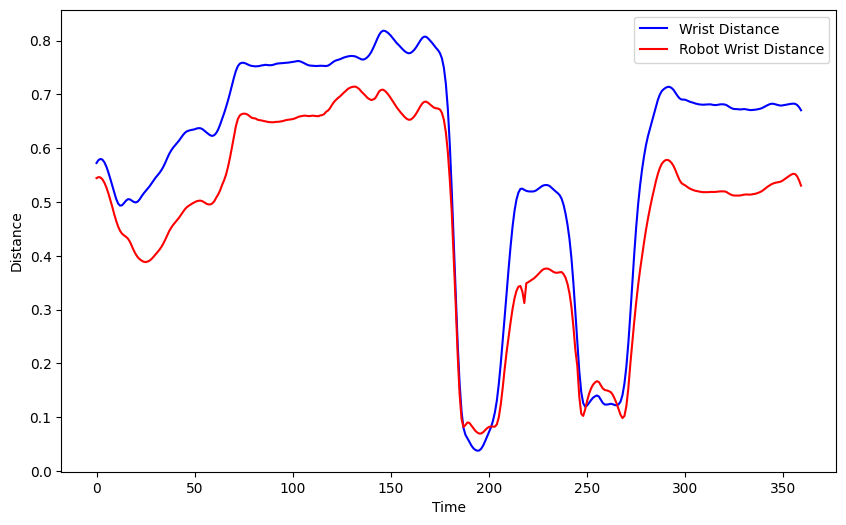

In [515]:
robot_wrist_dist_array = np.array(robot_wrist_dist_list)

import matplotlib.pyplot as plt

time = np.arange(0, robot_wrist_dist_array.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(time, wrist_dist_array, 'b-', label='Wrist Distance')
plt.plot(time, robot_wrist_dist_array, 'r-', label='Robot Wrist Distance')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

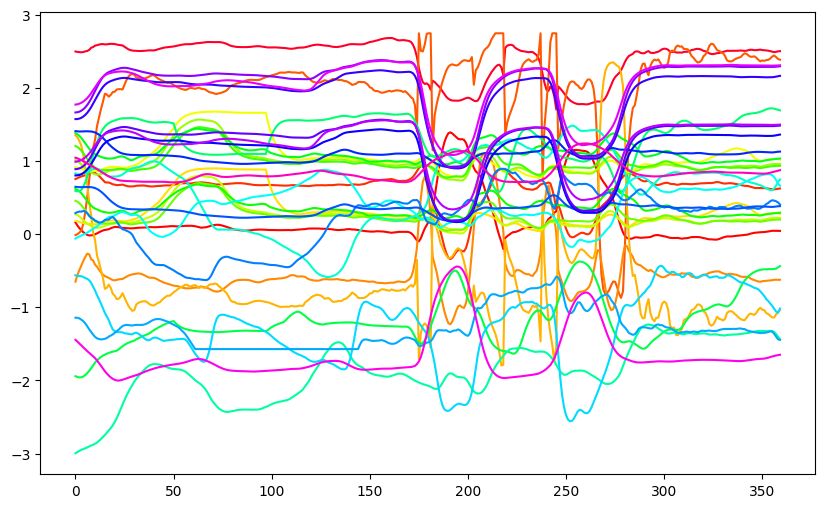

In [516]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_array.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_array.shape[1])]
for i in range(q_robot_array.shape[1]):
    plt.plot(time, q_robot_array[:,i], color=cs[i])

In [517]:
import mujoco,time
sys.path.append('../utils')
from mujoco_parser import init_ik_info,add_ik_info,get_dq_from_ik_info
from utility import smooth_optm_1d

joint_names_for_ik = env.rev_joint_names
collision_push_len = 0.01
gap_per_step_cm = 0.01
max_gap_cm = 2.0
acc_limit = 500
max_ik_tick = 100
body_name_to_exlude = "world"
left_hand_names = ['robot1/end_link',
    'robot1/index_L1', 'robot1/index_L2', 'robot1/index_tip', 
    'robot1/middle_L1', 'robot1/middle_L2', 'robot1/middle_tip',
    'robot1/ring_L1', 'robot1/ring_L2', 'robot1/ring_tip',
    'robot1/pinky_L1', 'robot1/pinky_L2', 'robot1/pinky_tip',
    'robot1/thumb_L1', 'robot1/thumb_L2', 'robot1/thumb_tip',
    ]
right_hand_names = ['robot2/end_link',
    'robot2/index_L1', 'robot2/index_L2', 'robot2/index_tip',
    'robot2/middle_L1', 'robot2/middle_L2', 'robot2/middle_tip',
    'robot2/ring_L1', 'robot2/ring_L2', 'robot2/ring_tip',
    'robot2/pinky_L1', 'robot2/pinky_L2', 'robot2/pinky_tip',
    'robot2/thumb_L1', 'robot2/thumb_L2', 'robot2/thumb_tip'
    ]

L = final_len
qpos_array = q_robot_array.copy()

ch_step = 0
while True:
    # if ch_step == 35: 
    #     collision_push_len /= 5
    #     gap_per_step_cm /= 5
    collision_gap_cm = ch_step * gap_per_step_cm
    if collision_gap_cm > max_gap_cm:
        collision_gap_cm = max_gap_cm
    env.model.geom_gap = collision_gap_cm / 100
    env.model.geom_margin = collision_gap_cm / 100

    qpos_cf_list = []
    n_sc = 0
    time_bc = time.time()

    for tick in range(L):
        env.forward(q=qpos_array[tick,:])
        sc_occured = False

        for ik_tick in range(max_ik_tick):
            p_contact_list,f_contact_list = [],[]
            contact_body1_list, contact_body2_list = [],[]
            
            for c_idx in range(env.data.ncon):
                contact = env.data.contact[c_idx]
                p_contact = contact.pos
                R_frame = contact.frame.reshape((3,3))

                f_contact_local = np.zeros(6,dtype=np.float64)
                mujoco.mj_contactForce(env.model,env.data,0,f_contact_local)
                f_contact = R_frame @ f_contact_local[:3]
                f_contact = np_uv(f_contact)

                contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
                contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

                if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                    continue

                if (contact_body1 in left_hand_names) and (contact_body2 in left_hand_names):
                    continue

                if (contact_body1 in right_hand_names) and (contact_body2 in right_hand_names):
                    continue

                # print("Contact between [%s] and [%s] at tick [%d]"%(contact_body1,contact_body2,tick))

                p_contact_list.append(p_contact)
                f_contact_list.append(f_contact)
                contact_body1_list.append(contact_body1)
                contact_body2_list.append(contact_body2)

            ik_info_collision = init_ik_info()
            n_contact = len(p_contact_list)

            if n_contact > 0:
                sc_occured = True
                for c_idx in range(n_contact):
                    f_contact = f_contact_list[c_idx]
                    contact_body1 = contact_body1_list[c_idx]
                    contact_body2 = contact_body2_list[c_idx]
                    p_body1 = env.get_p_body(body_name=contact_body1)
                    p_body2 = env.get_p_body(body_name=contact_body2)

                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body1,
                        p_trgt = p_body1 - collision_push_len * np_uv(f_contact)   
                    )
                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body2,
                        p_trgt = p_body2 + collision_push_len * np_uv(f_contact)
                    )
                
                joint_idxs_jac_collision = env.get_idxs_jac(joint_names=joint_names_for_ik)
                dq,ik_err_stack = get_dq_from_ik_info(
                    env=env,
                    ik_info=ik_info_collision,
                    stepsize=1,
                    eps=1e-2,
                    th=np.radians(3.0),
                    joint_idxs_jac=joint_idxs_jac_collision,
                )

                qpos = env.data.qpos.copy()
                mujoco.mj_integratePos(env.model,qpos,dq,1)
                qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
                env.forward(q=qpos)

            else:
                break
        
        if sc_occured: n_sc = n_sc + 1
        qpos_cf_list.append(env.data.qpos.copy())

    time_ac = time.time()
    print ("[%d] [step-1:collision handling] n_sc:[%d] collision_gap:[%.2f]cm time taken:[%f]s"%(ch_step,n_sc,collision_gap_cm,time_ac-time_bc))

    time_bs = time.time()
    qpos_cf_array = np.array(qpos_cf_list)
    qpos_cf_smt_array = qpos_cf_array.copy()

    for d_idx in env.get_idxs_fwd(joint_names=joint_names_for_ik):
        qpos_cf_smt_array[:,d_idx] = smooth_optm_1d(
            traj      = qpos_cf_array[:,d_idx],
            dt        = env.dt,
            acc_limit = acc_limit,
        )

    env.model.geom_gap = 0
    env.model_geom_margin = 0
    n_sc = 0

    for tick in range(L):
        q_cf_smt = qpos_cf_smt_array[tick,:]
        env.forward(q=q_cf_smt)
        sc_occured = False

        p_contact_list,f_contact_list = [],[]
        contact_body1_list,contact_body2_list = [],[]

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]
            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue
            if (contact_body1 in left_hand_names) and (contact_body2 in left_hand_names):
                continue
            if (contact_body1 in right_hand_names) and (contact_body2 in right_hand_names):
                continue
            sc_occured = True

        if sc_occured: n_sc = n_sc + 1

    qpos_array = qpos_cf_smt_array.copy()
    for i in range(qpos_array.shape[0]):
        qpos = qpos_array[i,:]
        qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
        qpos_array[i,:] = qpos

    time_as = time.time()
    print ("[%d] [step-2:smoothing] n_sc:[%d] time taken:[%f]s"%(ch_step,n_sc,time_as-time_bs))

    if n_sc == 0: break

    ch_step = ch_step + 1

q_robot_array_cf_smoothed = qpos_array

[0] [step-1:collision handling] n_sc:[21] collision_gap:[0.00]cm time taken:[0.175122]s
[0] [step-2:smoothing] n_sc:[0] time taken:[0.520238]s


In [518]:
n_c = 1
q_robot_array_hand_cf = q_robot_array_cf_smoothed.copy()

while n_c > 0:
    n_c = 0
    for tick in range(L):
        q_robot = q_robot_array_hand_cf[tick,:]
        env.forward(q=q_robot)

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]

            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue
            
            if (contact_body1=="robot1/thumb_L2") or (contact_body2=="robot1/thumb_L2"):
                q_robot[15] -= 0.01

            if (contact_body1=="robot2/thumb_L2") or (contact_body2=="robot2/thumb_L2"):
                q_robot[31] -= 0.01

            n_c += 1
            q_robot_array_hand_cf[tick,:] = q_robot

    print("[step-1:collision handling] n_c:[%d]"%n_c)

    n_c = 0
    q_robot_array_hand_cf_smoothed = q_robot_array_hand_cf.copy()
    for d_idx in get_idxs(env.rev_joint_names,JOINT_NAMES):
            qpos_cf_smt_array[:,d_idx] = smooth_optm_1d(
            traj      = qpos_cf_array[:,d_idx],
            dt        = env.dt,
            acc_limit = 100,
        )
            
    for tick in range(L):
        q_robot = q_robot_array_hand_cf[tick,:]
        env.forward(q=q_robot)

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]

            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue
            
            n_c += 1
            q_robot_array_hand_cf_smoothed[tick,:] = q_robot

    print("[step-2:smoothing] n_c:[%d]"%n_c) 

[step-1:collision handling] n_c:[211]
[step-2:smoothing] n_c:[202]
[step-1:collision handling] n_c:[202]
[step-2:smoothing] n_c:[192]
[step-1:collision handling] n_c:[192]
[step-2:smoothing] n_c:[186]
[step-1:collision handling] n_c:[186]
[step-2:smoothing] n_c:[179]
[step-1:collision handling] n_c:[179]
[step-2:smoothing] n_c:[174]
[step-1:collision handling] n_c:[174]
[step-2:smoothing] n_c:[161]
[step-1:collision handling] n_c:[161]
[step-2:smoothing] n_c:[133]
[step-1:collision handling] n_c:[133]
[step-2:smoothing] n_c:[100]
[step-1:collision handling] n_c:[100]
[step-2:smoothing] n_c:[72]
[step-1:collision handling] n_c:[72]
[step-2:smoothing] n_c:[59]
[step-1:collision handling] n_c:[59]
[step-2:smoothing] n_c:[54]
[step-1:collision handling] n_c:[54]
[step-2:smoothing] n_c:[49]
[step-1:collision handling] n_c:[49]
[step-2:smoothing] n_c:[44]
[step-1:collision handling] n_c:[44]
[step-2:smoothing] n_c:[39]
[step-1:collision handling] n_c:[39]
[step-2:smoothing] n_c:[36]
[step-1:

In [519]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = False

video = []
robot_wrist_dist_smoothed_list = []
robot_lw_pos_list = []
robot_rw_pos_list = []
robot_lw_rot_list = []
robot_rw_rot_list = []

plot_tick = 0
q_robot_export = np.zeros((final_len,env.model.nq))

while plot_tick < final_len and env.is_viewer_alive():
    q_robot = q_robot_array_hand_cf_smoothed[plot_tick,:]
    env.forward(q=q_robot,INCREASE_TICK=True)
    robot_left_wrist_pos = env.get_p_body('robot1/end_link')
    robot_right_wrist_pos = env.get_p_body('robot2/end_link')
    robot_left_wrist_rot = env.get_R_body('robot1/end_link')
    robot_right_wrist_rot = env.get_R_body('robot2/end_link')
    robot_lw_pos_list.append(robot_left_wrist_pos)
    robot_rw_pos_list.append(robot_right_wrist_pos)
    robot_lw_rot_list.append(robot_left_wrist_rot)
    robot_rw_rot_list.append(robot_right_wrist_rot)
    robot_wrist_dist = np.linalg.norm(robot_left_wrist_pos - robot_right_wrist_pos)
    robot_wrist_dist_smoothed_list.append(robot_wrist_dist)
    robot_wrist_pos = np.vstack((robot_left_wrist_pos,robot_right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    # env.plot_traj(robot_wrist_pos,rgba=[0,1,0,1],plot_line=True,plot_sphere=True,sphere_r=0.005) # wrist distance
    env.plot_contact_info(h_arrow=0.01,rgba_arrow=[1,0,0,0],PRINT_CONTACT_BODY=True,PLOT_SPHERE=False) # contact
    env.render()
    
    q_robot_export[plot_tick,:] = q_robot
    video.append(env.grab_image())
    plot_tick += 1
    # if plot_tick == final_len:
    #     if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=800)

In [520]:
# robot_wrist_dist_smoothed_array = np.array(robot_wrist_dist_smoothed_list)

# import matplotlib.pyplot as plt

# time = np.arange(0, robot_wrist_dist_smoothed_array.shape[0])
# plt.figure(figsize=(10, 6))
# plt.plot(time, wrist_dist_array, 'b-', label='Wrist Distance')
# plt.plot(time, robot_wrist_dist_array, 'r-', label='Robot Wrist Distance')
# plt.plot(time, robot_wrist_dist_smoothed_array, 'g-', label='Robot Wrist Distance Smoothed')

# plt.xlabel('Time')
# plt.ylabel('Distance')
# plt.legend()

# plt.show()

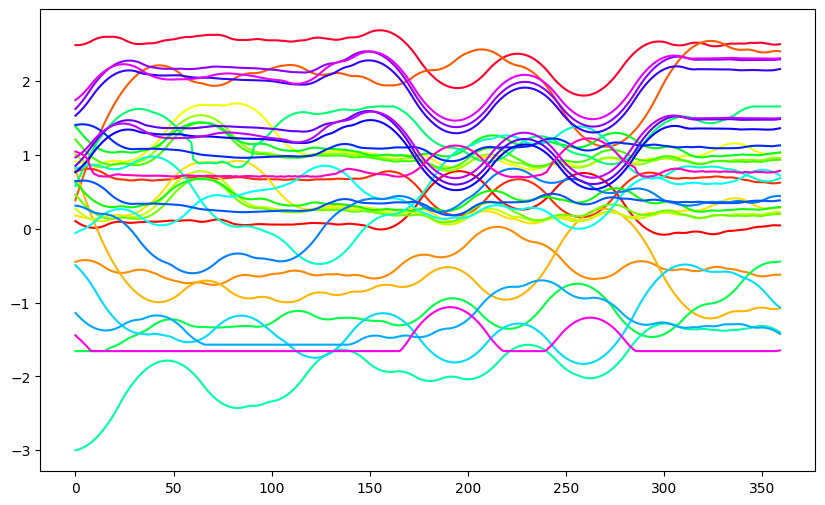

In [521]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_export.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_export.shape[1])]
for i in range(q_robot_array_cf_smoothed.shape[1]):
    plt.plot(time, q_robot_export[:,i], color=cs[i])

In [522]:
header_name = 'robot1/joint1,robot1/joint2,robot1/joint3,robot1/joint4,robot1/joint5,robot1/joint6,\
               robot1/index_q1,robot1/index_q2,robot1/middle_q1,robot1/middle_q2,robot1/ring_q1,robot1/ring_q2,robot1/pinky_q1,robot1/pinky_q2,robot1/thumb_q1,robot1/thumb_q2,\
               robot2/joint1,robot2/joint2,robot2/joint3,robot2/joint4,robot2/joint5,robot2/joint6,\
               robot2/index_q1,robot2/index_q2,robot2/middle_q1,robot2/middle_q2,robot2/ring_q1,robot2/ring_q2,robot2/pinky_q1,robot2/pinky_q2,robot2/thumb_q1,robot2/thumb_q2'

np.savetxt(
    fname="csv/"+str(data_numbers[0]) + "_" + str(data_numbers[-1]) + ".csv",
    # fname="dualarms_test.csv",
    X=q_robot_export[:final_len,:],
    delimiter=',',
    # header=header_name,
    fmt='%.6f'
    )

In [523]:
smplh_lw_pos_array = np.array(smplh_lw_pos_list)
smplh_rw_pos_array = np.array(smplh_rw_pos_list)

robot_lw_pos_array = np.array(robot_lw_pos_list)
robot_rw_pos_array = np.array(robot_rw_pos_list)

scaled_smplh_lw_pos_array = robot_left_shoulder_pos + (np.array(smplh_lw_pos_list)-smplh_left_shoulder_pos)*robot_arm_length/smplh_arm_length
scaled_smplh_rw_pos_array = robot_right_shoulder_pos + (np.array(smplh_rw_pos_list)-smplh_right_shoulder_pos)*robot_arm_length/smplh_arm_length

scaled_robot_lw_pos_array = smplh_left_shoulder_pos + (np.array(robot_lw_pos_list)-robot_left_shoulder_pos)*smplh_arm_length/robot_arm_length
scaled_robot_rw_pos_array = smplh_right_shoulder_pos + (np.array(robot_rw_pos_list)-robot_right_shoulder_pos)*smplh_arm_length/robot_arm_length

In [524]:
# xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
# env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=False)
# env.set_geom_color(
#     rgba                = (0.2,0.2,0.2,0.9),
#     body_names_to_color = [
#         'robot1/end_link','robot1/index_L1','robot1/index_L2','robot1/index_tip',
#         'robot1/middle_L1','robot1/middle_L2','robot1/middle_tip',
#         'robot1/ring_L1','robot1/ring_L2','robot1/ring_tip',
#         'robot1/pinky_L1','robot1/pinky_L2','robot1/pinky_tip',
#         'robot1/thumb_L1','robot1/thumb_L2','robot1/thumb_tip',
#         'robot2/end_link','robot2/index_L1','robot2/index_L2','robot2/index_tip',
#         'robot2/middle_L1','robot2/middle_L2','robot2/middle_tip',
#         'robot2/ring_L1','robot2/ring_L2','robot2/ring_tip',
#         'robot2/pinky_L1','robot2/pinky_L2','robot2/pinky_tip',
#         'robot2/thumb_L1','robot2/thumb_L2','robot2/thumb_tip'],
# )

# env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
#                 viewer_hide_menus=True)
# env.update_viewer(azimuth=180,distance=2.35,elevation=-7.2,lookat=[0.02,-0.018,1.4])
# env.reset()

# PLOT_TRAJ = False
# PLOT_LABEL = True
# SAVE_VIDEO = False
# video = []

# plot_tick = 0
# line_radius = 0.0015

# while plot_tick < final_len and env.is_viewer_alive():
#     q_robot = q_robot_array_hand_cf_smoothed[plot_tick,:]
#     # q_robot = np.zeros(env.model.nq)
#     env.forward(q=q_robot,INCREASE_TICK=True)
#     env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)

#     if PLOT_TRAJ == True:
#         env.plot_traj_thick(scaled_smplh_lw_pos_array,rgba=[0,1,0,0.35],plot_line=True,plot_sphere=False,line_r=line_radius)
#         if PLOT_LABEL: env.plot_T(p=scaled_smplh_lw_pos_array[-1],R=np.eye(3),label="SMPL-H Left Wrist",PLOT_AXIS=False)
#         env.plot_traj_thick(scaled_smplh_rw_pos_array,rgba=[0,1,1,0.35],plot_line=True,plot_sphere=False,line_r=line_radius)
#         if PLOT_LABEL: env.plot_T(p=scaled_smplh_rw_pos_array[-1],R=np.eye(3),label="SMPL-H Right Wrist",PLOT_AXIS=False)
        
#         env.plot_traj_thick(robot_lw_pos_array[:plot_tick],rgba=[1,0,0,1],plot_line=True,plot_sphere=False,line_r=line_radius*2)
#         if PLOT_LABEL: env.plot_T(p=robot_lw_pos_array[plot_tick],R=np.eye(3),label="Robot Left Wrist",PLOT_AXIS=False)
#         env.plot_traj_thick(robot_rw_pos_array[:plot_tick],rgba=[1,0.5,0,1],plot_line=True,plot_sphere=False,line_r=line_radius*2)
#         if PLOT_LABEL: env.plot_T(p=robot_rw_pos_array[plot_tick],R=np.eye(3),label="Robot Right Wrist",PLOT_AXIS=False)
#     env.render()
    
#     video.append(env.grab_image())
#     plot_tick += 1
#     if plot_tick == final_len:
#         if not SAVE_VIDEO: plot_tick = 0

# env.close_viewer()
# if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=800)

In [525]:
from scipy.spatial import procrustes

# smplh_wrist_array = np.hstack((smplh_lw_pos_array,smplh_rw_pos_array))
# robot_wrist_array = np.hstack((robot_lw_pos_array,robot_rw_pos_array))

# _, _, disparity = procrustes(smplh_wrist_array,robot_wrist_array)
# print(disparity)

la, lb, ld = procrustes(smplh_lw_pos_array,robot_lw_pos_array)
print("Left:", ld)

ra, rb, rd = procrustes(smplh_rw_pos_array,robot_rw_pos_array)
print("Right:", rd)

Left: 0.19299279197074296
Right: 0.03798335201544969
